In [42]:
# Импортируем классические модули для анализа данных: numpy и pandas для работы с датафреймами и векторами, и pyplot
# для графиков
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [44]:
#Импортирование исторических цен (предварительно необходиом загрузить hist_price.csv в рабочую директорию в Jupiter)
df = pd.read_csv("hist_price.csv",sep=',')    
df.head(15)

,TIME,OPEN,LOW,HIGH,CLOSE
0,1,103.45,103.08,103.53,103.20
1,2,103.19,103.15,103.29,103.29
2,3,103.29,103.25,103.49,103.48
3,4,103.48,103.40,103.54,103.44
4,5,103.43,103.30,103.45,103.33
5,6,103.31,103.19,103.38,103.27
6,7,103.25,103.25,103.45,103.35
7,8,103.39,103.30,103.40,103.32
8,9,103.31,103.17,103.31,103.20
9,10,103.20,102.98,103.20,103.08


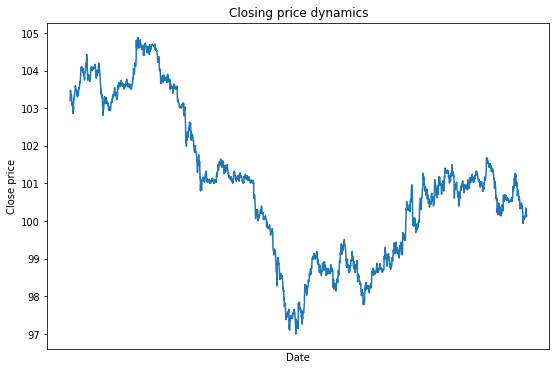

In [45]:
#построение графика цен закрытия
plt.figure (figsize=(9,6))
x=df['TIME']
y=df['CLOSE']
plt.plot(x,y)
plt.xticks([])
plt.xlabel('Date')
plt.ylabel('Close price')
plt.title('Closing price dynamics')
plt.show()

In [46]:
#добавление столбцов: доходности, средней доходности по а значениям и по значениям а-1
a = 20
df['RETURN'] = df['CLOSE'] / df['CLOSE'].shift()-1
df['MA_return'] = df['RETURN'].rolling(a).mean()
df['MA_return_prev'] = df['MA_return'].shift()
df = df.dropna()
df.head(15)

,TIME,OPEN,LOW,HIGH,CLOSE,RETURN,MA_return,MA_return_prev
21,22,103.37,103.23,103.48,103.38,0.000097,0.000044,0.000083
22,23,103.38,103.32,103.45,103.44,0.000580,-0.000019,0.000044
23,24,103.41,103.38,103.46,103.46,0.000193,0.000010,-0.000019
24,25,103.45,103.40,103.74,103.60,0.001353,0.000131,0.000010
25,26,103.56,103.49,103.74,103.56,-0.000386,0.000141,0.000131
26,27,103.53,103.49,103.58,103.52,-0.000386,0.000083,0.000141
27,28,103.55,103.49,103.57,103.50,-0.000193,0.000088,0.000083
28,29,103.50,103.47,103.54,103.48,-0.000193,0.000136,0.000088
29,30,103.48,103.48,103.50,103.49,0.000097,0.000199,0.000136
30,31,103.49,103.46,103.54,103.46,-0.000290,0.000151,0.000199


In [47]:
#Импорт библиотеки для проверки автокорреляции и частичной автокррекляции
from scipy import stats

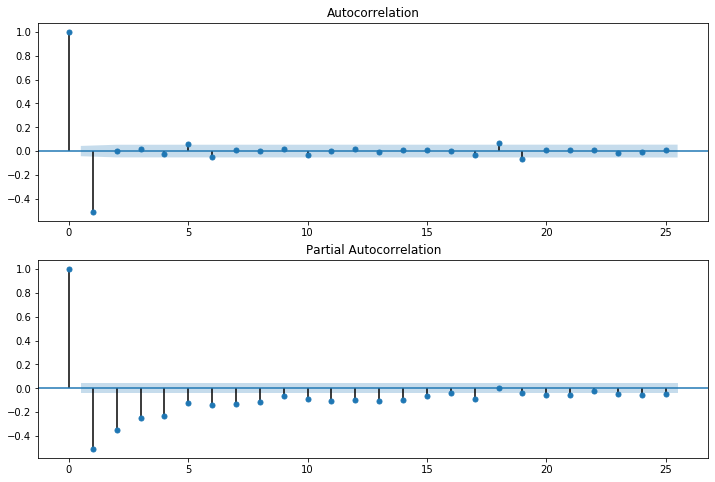

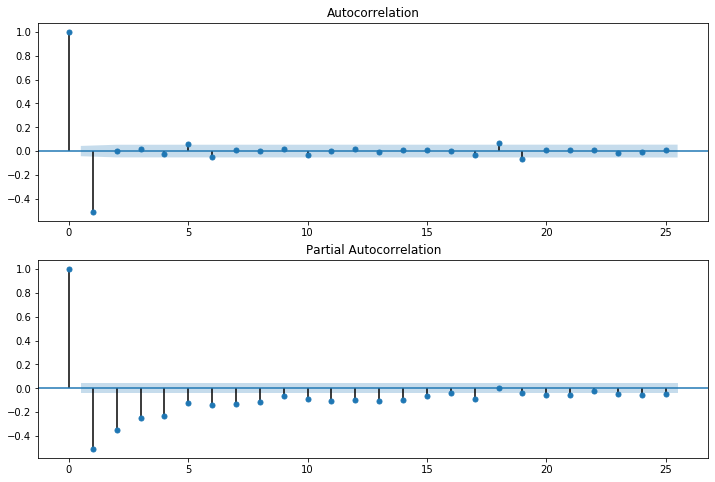

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# для посчёта функции при разных значениях лага

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
plot_acf(df.RETURN.diff().dropna(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(df.RETURN.diff().dropna(), lags=25, ax=ax2)

In [49]:
#расчет статистических характеристик
import numpy as np
np.var(df['RETURN'])

8.446614763718728e-07

In [50]:
from scipy import stats

mean = df['RETURN'].mean()
std = df['RETURN'].std()

skew = df['RETURN'].skew()
kurtosis = df['RETURN'].kurtosis()
print('mean: ',mean)
print('std:', std)
print('skew:',skew)
print('kurtosis:',kurtosis)

mean:  -1.5044016806087682e-05
std: 0.0009192779257052059
skew: 0.05421526623452818
kurtosis: 5.101283196693037


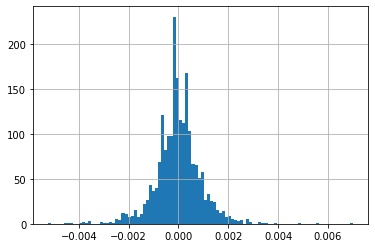

In [51]:
df['RETURN'].hist(bins=100)
# Show the plot
plt.show()

Мы видим, что среднее приблизительно равно 0 и стандартное отклонение довольно низкое, skewness около нуля, а kurtosis чуть выше 5, что может говорить о нормальности распределения. К тому же, график распределения похож на график нормального (приблизительно похож).

### Проверка нормальности распределения доходностей

In [52]:
# импортируем библиотеку и проводим тест Колмогорова-Смирнова на определения нормальности распределения доходностей
# Нулевая гипотеза: Доходности распределены нормально
from scipy.stats import kstest


In [53]:
ad = kstest(df['RETURN'][21:2080],'norm')
print(ad)

KstestResult(statistic=0.4979166533049981, pvalue=0.0)


Нулевая гипотеза отвергнута, поскольку p-value равен 0. Следовательно, доходность не распределена нормально
Однако статистические показатели и график показали, что доходности распределены нормальны. Поэтому сделаем вывод о нормальности распределения доходностей. Далее будем основываться на данной предпосылке

# Проверка стационарности распределения доходностей

In [55]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
test = sm.tsa.adfuller(df['RETURN'][1:2079])
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -46.74110291657871
p-value:  0.0
Critical values:  {'1%': -3.433533023432548, '5%': -2.8629461097716633, '10%': -2.567518549139982}
единичных корней нет, ряд стационарен


In [56]:
import matplotlib.pyplot as plt
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['RETURN'][1:2079])[1])
plt.tight_layout()

Критерий Дики-Фуллера: p=0.000000


<Figure size 432x288 with 0 Axes>

Таким образом, ряд стационарен. Поэтому приведение ряда к стационарному не требуется.

# Стратегия Momentum

In [57]:
returns = df['RETURN'].values
MA_returns = df['MA_return'].values
MA_returns_prev = df['MA_return_prev'].values
print(len(returns))

2059


In [58]:
# Суть стратегии: если МА больше нуля открываем длинную позицию, если меньше - короткую, если равна 0 - ничего не делаем
# Посчитаем доходности по каждой сделки
profits_momentum = [] 
for i in range(0, len(MA_returns_prev)):

    if (MA_returns_prev[i] > 0 and returns[i]>0) or (MA_returns_prev[i] < 0 and returns[i]<0):
        profits_momentum.append(abs(returns[i]))
    elif (MA_returns_prev[i] > 0 and returns[i]<0) or (MA_returns_prev[i] < 0 and returns[i]>0):
        profits_momentum.append(-abs(returns[i]))
    elif MA_returns_prev[i]==0 or returns[i]==0:
        profits_momentum.append(0)
print(profits_momentum)
print(len(profits_momentum))

[9.673986649882949e-05, 0.0005803830528148257, -0.00019334880123733633, 0.0013531799729364913, -0.0003861003861003187, -0.00038624951718813083, -0.00019319938176198814, -0.00019323671497584183, 9.66370313102427e-05, -0.000289883080490827, -0.0009665571235258907, -0.00029024767801855145, 0.0002903319461917686, -0.0005804953560372139, 0.0009680542110359625, 0.0005802707930366857, -0.0010632128358786241, 0.0003870343492986539, 0.0008704903762453142, 0.0006764592191728092, -0.00038628681796226694, 0.0004830451164139493, 0, 0.0011587485515642815, 0.00028935185185163803, -0.00028926815157637176, 0.0004822530864196928, 0.0014460618914489132, 0.0009626492106278306, 0.0009617234083476589, 0, -9.607993850890839e-05, 0.00028826751225130565, -0.000768491834774232, 0.0006729475100943905, -0.0006724949562878502, 0.000480676792924406, -0.00019217834150087043, -0.0009610764055741905, 0.0009620009620008307, -0.00028832292167224605, -0.0007690828686790496, -9.620935154885935e-05, -0.0007697488694314858,

# Стретегия Mean reversion

In [59]:
# Суть стратегии: если МА больше нуля открываем короткую позицию, если меньше - длинную, если равна 0 - ничего не делаем
profits_reversion = [] 
for i in range(0, len(MA_returns_prev)):

    if (MA_returns_prev[i] < 0 and returns[i]>0) or (MA_returns_prev[i] > 0 and returns[i]<0):
        profits_reversion.append(abs(returns[i]))
    elif (MA_returns_prev[i] < 0 and returns[i]<0) or (MA_returns_prev[i] > 0 and returns[i]>0):
        profits_reversion.append(-abs(returns[i]))
    elif MA_returns_prev[i]==0 or returns[i]==0:
        profits_reversion.append(0)
print(profits_reversion)
print(len(profits_reversion))

[-9.673986649882949e-05, -0.0005803830528148257, 0.00019334880123733633, -0.0013531799729364913, 0.0003861003861003187, 0.00038624951718813083, 0.00019319938176198814, 0.00019323671497584183, -9.66370313102427e-05, 0.000289883080490827, 0.0009665571235258907, 0.00029024767801855145, -0.0002903319461917686, 0.0005804953560372139, -0.0009680542110359625, -0.0005802707930366857, 0.0010632128358786241, -0.0003870343492986539, -0.0008704903762453142, -0.0006764592191728092, 0.00038628681796226694, -0.0004830451164139493, 0, -0.0011587485515642815, -0.00028935185185163803, 0.00028926815157637176, -0.0004822530864196928, -0.0014460618914489132, -0.0009626492106278306, -0.0009617234083476589, 0, 9.607993850890839e-05, -0.00028826751225130565, 0.000768491834774232, -0.0006729475100943905, 0.0006724949562878502, -0.000480676792924406, 0.00019217834150087043, 0.0009610764055741905, -0.0009620009620008307, 0.00028832292167224605, 0.0007690828686790496, 9.620935154885935e-05, 0.0007697488694314858,

# Стретегия Hurst

In [60]:
import nolds
import warnings
warnings.filterwarnings('ignore')

In [61]:
# Суть стратегии:
# Если Херста больше 0,5, то действия такие же как и в стратегии Momentum 
# Если Херста меньше 0,5, то действия такие же как и в стратегии Mean Reversion
profit_hurst=[]

for i in range(0,len(returns)):
    h_exp = nolds.hurst_rs(returns[i:i+19])
#     mean = returns[i:i+19].mean()
    if h_exp>0.5:
        if (MA_returns_prev[i] > 0 and returns[i]>0) or (MA_returns_prev[i] < 0 and returns[i]<0):
            profit_hurst.append(abs(returns[i]))
        elif (MA_returns_prev[i] < 0 and returns[i]>0) or (MA_returns_prev[i] > 0 and returns[i]<0):
            profit_hurst.append(-abs(returns[i]))
        elif MA_returns_prev[i]==0 or returns[i]==0:
            profit_hurst.append(0)
    elif h_exp<0.5:
        if (MA_returns_prev[i] > 0 and returns[i]>0) or (MA_returns_prev[i] < 0 and returns[i]<0):
            profit_hurst.append(-abs(returns[i]))
        elif (MA_returns_prev[i] < 0 and returns[i]>0) or (MA_returns_prev[i] > 0 and returns[i]<0):
            profit_hurst.append(abs(returns[i]))
        elif MA_returns_prev[i]==0 or returns[i]==0:
            profit_hurst.append(0)
    else:
        profit_hurst.append(0)
print(profit_hurst)
print(len(profit_hurst))

[-9.673986649882949e-05, -0.0005803830528148257, -0.00019334880123733633, -0.0013531799729364913, -0.0003861003861003187, -0.00038624951718813083, 0.00019319938176198814, 0.00019323671497584183, -9.66370313102427e-05, 0.000289883080490827, 0.0009665571235258907, -0.00029024767801855145, -0.0002903319461917686, -0.0005804953560372139, 0.0009680542110359625, 0.0005802707930366857, 0.0010632128358786241, 0.0003870343492986539, 0.0008704903762453142, -0.0006764592191728092, 0.00038628681796226694, -0.0004830451164139493, 0, 0.0011587485515642815, -0.00028935185185163803, -0.00028926815157637176, 0.0004822530864196928, -0.0014460618914489132, -0.0009626492106278306, 0.0009617234083476589, 0, 9.607993850890839e-05, -0.00028826751225130565, -0.000768491834774232, -0.0006729475100943905, 0.0006724949562878502, -0.000480676792924406, 0.00019217834150087043, -0.0009610764055741905, -0.0009620009620008307, 0.00028832292167224605, -0.0007690828686790496, -9.620935154885935e-05, 0.00076974886943148

# Стретегия Стохастик

In [98]:
# Снова создаем таблицу по историческим данным, так как в старой отсутсвуют данные за период 0-20
data = pd.read_csv("hist_price.csv",sep=',')    
data.head()


,TIME,OPEN,LOW,HIGH,CLOSE
0,1,103.45,103.08,103.53,103.20
1,2,103.19,103.15,103.29,103.29
2,3,103.29,103.25,103.49,103.48
3,4,103.48,103.40,103.54,103.44
4,5,103.43,103.30,103.45,103.33


In [99]:
#Create the "L14" column in the DataFrame

data['L14'] = data['LOW'].rolling(window=14).min()

#Create the "H14" column in the DataFrame
data['H14'] = data['HIGH'].rolling(window=14).max()

#Create the "%K" column in the DataFrame
data['%K'] = 100*((data['CLOSE'] - data['L14']) / (data['H14'] - data['L14']) )

#Create the "%D" column in the DataFrame
data['%D'] = data['%K'].rolling(window=3).mean()

data.head(20)

,TIME,OPEN,LOW,HIGH,CLOSE,L14,H14,%K,%D
0,1,103.45,103.08,103.53,103.20,NaN,NaN,NaN,NaN
1,2,103.19,103.15,103.29,103.29,NaN,NaN,NaN,NaN
2,3,103.29,103.25,103.49,103.48,NaN,NaN,NaN,NaN
3,4,103.48,103.40,103.54,103.44,NaN,NaN,NaN,NaN
4,5,103.43,103.30,103.45,103.33,NaN,NaN,NaN,NaN
5,6,103.31,103.19,103.38,103.27,NaN,NaN,NaN,NaN
6,7,103.25,103.25,103.45,103.35,NaN,NaN,NaN,NaN
7,8,103.39,103.30,103.40,103.32,NaN,NaN,NaN,NaN
8,9,103.31,103.17,103.31,103.20,NaN,NaN,NaN,NaN
9,10,103.20,102.98,103.20,103.08,NaN,NaN,NaN,NaN


In [100]:
#формируем сигналы на покупку/продажу для стохастика
#Продажа начинается, когда линия% K пересекает линию% D и значение осциллятора выше 80.
data['Sell Entry'] = ((data['%K'] < data['%D']) & (data['%K'].shift(1) > data['%D'].shift(1))) & (data['%D'] >= 80)
#Покупка начинается, когда линия% K пересекает линию% D, а значение осциллятора ниже 20
data['Buy Entry'] = ((data['%K'] > data['%D']) & (data['%K'].shift(1) < data['%D'].shift(1))) & (data['%D'] <= 20) 

In [101]:
data.head(20)

,TIME,OPEN,LOW,HIGH,CLOSE,L14,H14,%K,%D,Sell Entry,Buy Entry
0,1,103.45,103.08,103.53,103.20,NaN,NaN,NaN,NaN,False,False
1,2,103.19,103.15,103.29,103.29,NaN,NaN,NaN,NaN,False,False
2,3,103.29,103.25,103.49,103.48,NaN,NaN,NaN,NaN,False,False
3,4,103.48,103.40,103.54,103.44,NaN,NaN,NaN,NaN,False,False
4,5,103.43,103.30,103.45,103.33,NaN,NaN,NaN,NaN,False,False
5,6,103.31,103.19,103.38,103.27,NaN,NaN,NaN,NaN,False,False
6,7,103.25,103.25,103.45,103.35,NaN,NaN,NaN,NaN,False,False
7,8,103.39,103.30,103.40,103.32,NaN,NaN,NaN,NaN,False,False
8,9,103.31,103.17,103.31,103.20,NaN,NaN,NaN,NaN,False,False
9,10,103.20,102.98,103.20,103.08,NaN,NaN,NaN,NaN,False,False


In [102]:
#присваиваем нулевые значения столбцу signal и избавляемся от nan в столбцах "быстрого"(%K) и "медленного"(%D) стохастика 
data['signal'] = 0
data['%K'] = data['%K'].fillna(0)
data['%D'] = data['%D'].fillna(0)
data.head()

,TIME,OPEN,LOW,HIGH,CLOSE,L14,H14,%K,%D,Sell Entry,Buy Entry,signal
0,1,103.45,103.08,103.53,103.20,NaN,NaN,0.0,0.0,False,False,0
1,2,103.19,103.15,103.29,103.29,NaN,NaN,0.0,0.0,False,False,0
2,3,103.29,103.25,103.49,103.48,NaN,NaN,0.0,0.0,False,False,0
3,4,103.48,103.40,103.54,103.44,NaN,NaN,0.0,0.0,False,False,0
4,5,103.43,103.30,103.45,103.33,NaN,NaN,0.0,0.0,False,False,0


In [104]:
#Заполняем столбец signal, используя логические значения, созданные выше
data.loc[data['Sell Entry'],'signal'] = -1 
data.loc[data['Buy Entry'],'signal'] = 1 
data.head(40)

,TIME,OPEN,LOW,HIGH,CLOSE,L14,H14,%K,%D,Sell Entry,Buy Entry,signal
0,1,103.45,103.08,103.53,103.20,NaN,NaN,0.000000,0.000000,False,False,0
1,2,103.19,103.15,103.29,103.29,NaN,NaN,0.000000,0.000000,False,False,0
2,3,103.29,103.25,103.49,103.48,NaN,NaN,0.000000,0.000000,False,False,0
3,4,103.48,103.40,103.54,103.44,NaN,NaN,0.000000,0.000000,False,False,0
4,5,103.43,103.30,103.45,103.33,NaN,NaN,0.000000,0.000000,False,False,0
5,6,103.31,103.19,103.38,103.27,NaN,NaN,0.000000,0.000000,False,False,0
6,7,103.25,103.25,103.45,103.35,NaN,NaN,0.000000,0.000000,False,False,0
7,8,103.39,103.30,103.40,103.32,NaN,NaN,0.000000,0.000000,False,False,0
8,9,103.31,103.17,103.31,103.20,NaN,NaN,0.000000,0.000000,False,False,0
9,10,103.20,102.98,103.20,103.08,NaN,NaN,0.000000,0.000000,False,False,0


In [105]:
data = data.iloc[11:]
data.head()

,TIME,OPEN,LOW,HIGH,CLOSE,L14,H14,%K,%D,Sell Entry,Buy Entry,signal
11,12,103.16,103.08,103.19,103.12,NaN,NaN,0.000000,0.000000,False,False,0
12,13,103.12,103.06,103.15,103.07,NaN,NaN,0.000000,0.000000,False,False,0
13,14,103.08,102.86,103.15,102.86,102.86,103.54,0.000000,0.000000,False,False,0
14,15,102.88,102.85,103.06,103.06,102.85,103.54,30.434783,0.000000,False,False,0
15,16,103.06,103.01,103.14,103.04,102.85,103.54,27.536232,19.323671,False,False,0


In [106]:
data['RETURN'] = data['CLOSE'] / data['CLOSE'].shift()-1
data.head()

,TIME,OPEN,LOW,HIGH,CLOSE,L14,H14,%K,%D,Sell Entry,Buy Entry,signal,RETURN
11,12,103.16,103.08,103.19,103.12,NaN,NaN,0.000000,0.000000,False,False,0,NaN
12,13,103.12,103.06,103.15,103.07,NaN,NaN,0.000000,0.000000,False,False,0,-0.000485
13,14,103.08,102.86,103.15,102.86,102.86,103.54,0.000000,0.000000,False,False,0,-0.002037
14,15,102.88,102.85,103.06,103.06,102.85,103.54,30.434783,0.000000,False,False,0,0.001944
15,16,103.06,103.01,103.14,103.04,102.85,103.54,27.536232,19.323671,False,False,0,-0.000194


In [108]:
data['RETURN'][11] = -0.000291
data.head()

,TIME,OPEN,LOW,HIGH,CLOSE,L14,H14,%K,%D,Sell Entry,Buy Entry,signal,RETURN
11,12,103.16,103.08,103.19,103.12,NaN,NaN,0.000000,0.000000,False,False,0,-0.000291
12,13,103.12,103.06,103.15,103.07,NaN,NaN,0.000000,0.000000,False,False,0,-0.000485
13,14,103.08,102.86,103.15,102.86,102.86,103.54,0.000000,0.000000,False,False,0,-0.002037
14,15,102.88,102.85,103.06,103.06,102.85,103.54,30.434783,0.000000,False,False,0,0.001944
15,16,103.06,103.01,103.14,103.04,102.85,103.54,27.536232,19.323671,False,False,0,-0.000194


In [111]:
data['STOCH_RETURN'] = data['RETURN'] * data['signal']
data['STOCH_RETURN'] = data['STOCH_RETURN'].fillna(0)
data.head()

,TIME,OPEN,LOW,HIGH,CLOSE,L14,H14,%K,%D,Sell Entry,Buy Entry,signal,RETURN,STOCH_RETURN
11,12,103.16,103.08,103.19,103.12,NaN,NaN,0.000000,0.000000,False,False,0,-0.000291,-0.0
12,13,103.12,103.06,103.15,103.07,NaN,NaN,0.000000,0.000000,False,False,0,-0.000485,-0.0
13,14,103.08,102.86,103.15,102.86,102.86,103.54,0.000000,0.000000,False,False,0,-0.002037,-0.0
14,15,102.88,102.85,103.06,103.06,102.85,103.54,30.434783,0.000000,False,False,0,0.001944,0.0
15,16,103.06,103.01,103.14,103.04,102.85,103.54,27.536232,19.323671,False,False,0,-0.000194,-0.0


# Расчет накопленных прибылей и построение графика

In [115]:
sma = []
for i in range(0, len(profits_momentum)):
    sma.append(sum(profits_momentum[0:i+1]))

In [116]:
reversion = []
for i in range(0, len(profits_reversion)):
    reversion.append(sum(profits_reversion[0:i+1]))

In [117]:
hurst = []
for i in range(0, len(profit_hurst)):
    hurst.append(sum(profit_hurst[0:i+1]))

In [112]:
stoch=[]
for i in range(0, len(data['STOCH_RETURN'])):
    stoch.append(sum(data['STOCH_RETURN'][0:i+1]))
stoch

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0013531799729364913,
 -0.0009668931549742243,
 -0.0009668931549742243,
 -0.0009668931549742243,
 -0.0009668931549742243,
 -0.0012562450068258624,
 -0.0012562450068258624,
 -0.0012562450068258624,
 -0.0012562450068258624,
 -0.0012562450068258624,
 -0.0022179684151735213,
 -0.0022179684151735213,
 -0.002121888476664613,
 -0.002121888476664613,
 -0.0013533966418903809,
 -0.0013533966418903809,
 -0.0006809016856025307,
 -0.0006809016856025307,
 -0.0004887233441016603,
 -0.0004887233441016603,
 -0.0004887233441016603,

In [113]:
stoch[-1]

0.06644529064905558

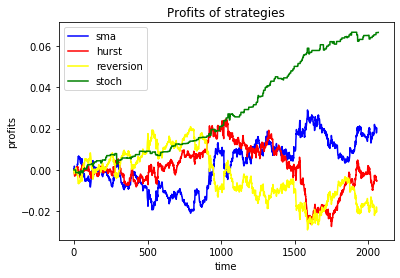

In [118]:
plt.plot(sma, color='blue')
plt.plot(hurst, color='red')
plt.plot(reversion, color='yellow')
plt.plot(stoch, color='green')
plt.legend(['sma','hurst','reversion','stoch'],loc='upper left')
plt.xlabel('time')
plt.ylabel('profits')
plt.title('Profits of strategies')
plt.show()

По графику можно увидеть, что самой доходной оказалась стратегия Стохастик

In [121]:
# Рассчитаем итоговую доходность 
profit_stoch = stoch [-1]*100
profit_stoch

6.644529064905558

Доходность стратегии Стохастик равна 6,64 %